# 기존과의 차이

- 기존에 미리 찾아둔 고성능 feature와 hyperparameter를 사용하여 성능 비교

1. 지역별 집값 평균을 추가 : **11282.954937**
2. 1번에서 time_to_sell을 제거 : **11287.759878** 
3. 1번에서 interest_rate를 제거 : **11290.584668** 
4. 1번에서 time_to_sell, interest_rate를 제거 : **11267.338671** 
5. 1번에서 time_to_sell, interest_rate, type_num을 제거 : **11246.669330**
6. 1번에서 time_to_sell, interest_rate, Month를 제거 : **11213.028786**

In [97]:
import pandas as pd #데이터 처리를 위한 pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler #모델 평가를 위한 scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import time
import itertools
import os
import gc
import pickle
from xgboost import XGBRegressor #모델 구축을 위한 XGBoost
from xgboost import plot_importance
from matplotlib import rcParams #시각화를 위한 matplotlib

# 그림 크기 설정: matplotlib의 그림 크기를 설정합니다.
rcParams['figure.figsize'] = 12, 6

In [186]:
#데이터 불러오기
try:
    test = pd.read_csv('Data/test.csv', encoding='utf-8')
    train = pd.read_csv('Data/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    #UTF-8로 실패한 경우 CP949로 재시도
    test = pd.read_csv('Data/test.csv', encoding='cp949')
    train = pd.read_csv('Data/train.csv', encoding='cp949')    

### Data Preprocessing

In [187]:
train['address'] = train['location'] + '/' + train['street']

In [188]:
train['type'].value_counts()
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in train['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
train['type_num'] = tmp

# 방개수 결측치 중앙값으로 -> execute 값을 none 값으로 했는데 그걸 median()메서드를 사용하여 전체 값의 중앙값으로 설정해줌
tmp = []

tmp = train['type_num'].fillna(train['type_num'].median())
train['type_num'] = tmp
train['type_num']

# 결측치 확인
train['type_num'].isna().sum()

0

In [189]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(train['type_num'], train['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
train['area_per_room'] = tmp

In [190]:
# 지역별 평균 집값으로 학습에 사용할 price를 생성

pivot_1 = pd.pivot_table(train, index='address', values='price', aggfunc=['count', 'mean', 'median'])
pivot_1.columns = ['count', 'mean', 'median']

In [191]:
tmp = []
for i in train['address']:
    for j in pivot_1.index:
        if i == j:
            tmp.append(pivot_1.loc[[i]]['mean'].values[0])

In [193]:
train['priceMean_inAddress'] = tmp

In [194]:
train

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress
0,199577,2006-09,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0,Raleigh/Agawan Court,5.0,22.000,388121.105812
1,217021,2007-06,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0,Fresno/Cleo St,3.0,21.333,247629.816410
2,308062,2010-09,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,Tucson/E Pleasant View Way,4.0,23.000,250972.789366
3,212465,2007-04,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,Austin/Park Hollow Ln,4.0,23.000,236038.387786
4,60654,2001-10,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,Honolulu/Ala Puawa Place,4.0,25.500,312744.576923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,Omaha/Sandra Ln,4.0,25.750,323124.984746
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,Omaha/Atkin Rd,5.0,26.800,437646.389041
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0,Boston/Kempton Street,5.0,23.600,415951.990544
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,Fresno/Magnolia Dale Dr,4.0,22.500,326226.186196


In [195]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['Year'] = tmp['date'].dt.year
train['Month'] = tmp['date'].dt.month
train.drop('date', axis = 1, inplace = True)

In [196]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(train['commence_date'], train['Year']):
    tmp_list.append(j-i)

train['time_to_sell'] = tmp_list

In [197]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('Data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [198]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(train['Year'], train['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [199]:
# 생성한 리스트를 dataframe에 합침
train['interest_rate'] = tmp_interest_rate

In [90]:
train

,house_id,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0,Raleigh/Agawan Court,5.0,22.000,388121.105812,2006,9,3,5.25
1,217021,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0,Fresno/Cleo St,3.0,21.333,247629.816410,2007,6,19,5.25
2,308062,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,Tucson/E Pleasant View Way,4.0,23.000,250972.789366,2010,9,34,0.25
3,212465,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,Austin/Park Hollow Ln,4.0,23.000,236038.387786,2007,4,30,5.25
4,60654,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,Honolulu/Ala Puawa Place,4.0,25.500,312744.576923,2001,10,3,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,Omaha/Sandra Ln,4.0,25.750,323124.984746,2003,1,14,1.25
271717,28297,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,Omaha/Atkin Rd,5.0,26.800,437646.389041,2000,11,4,6.50
271718,321995,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0,Boston/Kempton Street,5.0,23.600,415951.990544,2011,4,7,0.25
271719,308162,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,Fresno/Magnolia Dale Dr,4.0,22.500,326226.186196,2010,9,11,0.25


C:\Users\CHOI Je Woo\AppData\Local\Temp\ipykernel_25472\1534458401.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

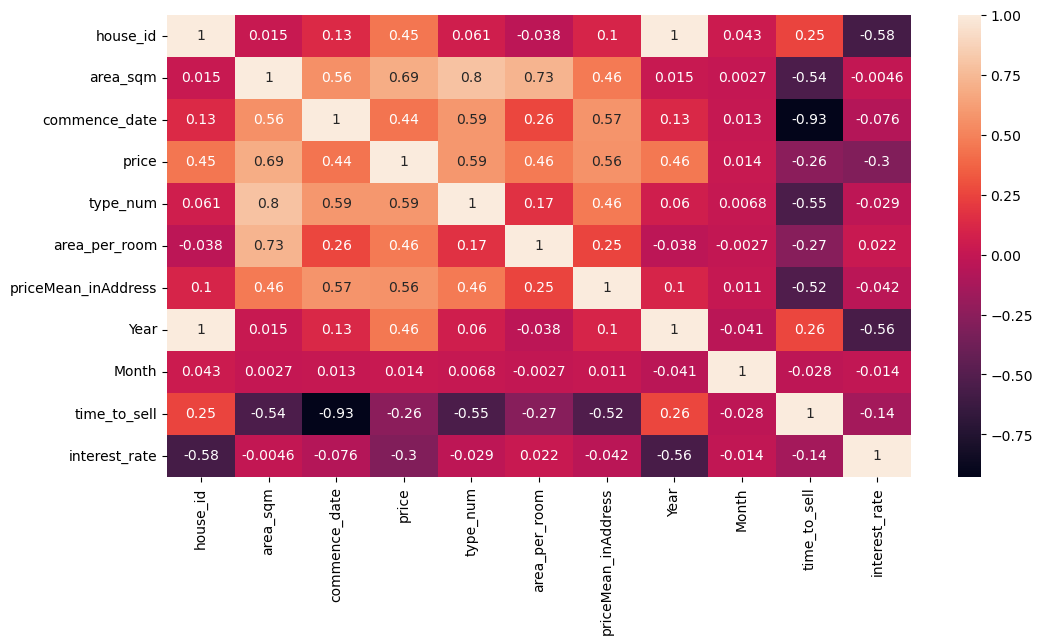

In [200]:
sns.heatmap(train.corr(), annot=True)

In [204]:
#라벨 인코딩: 모델이 이해하기 쉽도록 범주형 데이터를 숫자로 분류하여 줌

categorial_features = ['type', 'block', 'storey_range', 'flat_model', 'commence_date', 'address', 'Year', 'Month']
numerical_features = ['area_sqm', 'type_num', 'area_per_room', 'priceMean_inAddress', 'time_to_sell', 'interest_rate']

le = LabelEncoder()
for i in categorial_features:
    train[i] = le.fit_transform(train[i])

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

In [205]:
#라벨 인코딩 후 Object(문자열) 컬럼들을 제거 함.
#train = train.drop(['address', 'location', 'street', 'type'], axis = 1)
train = train.drop(['location', 'street'], axis = 1)

### CASE 1
- 지역별 집값 평균을 추가
- 높은 성능을 보인 400회 기준 300~500회 학습 구간 사이를 10회 단위로 나누어 성능확인

In [102]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,10,8,0.260870,0.00


In [106]:
X = train.drop(['price'], axis = 1)
y = train['price']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    n_estimators    train_mae      test_mae  train_r2   test_r2      time
0            300  8447.513948  11316.117486  0.989627  0.979257  5.828707
1            310  8375.272036  11311.424969  0.989812  0.979273  5.457836
2            320  8298.517951  11308.807723  0.990005  0.979282  5.407677
3            330  8238.851130  11306.393592  0.990145  0.979283  5.542860
4            340  8179.912908  11301.854275  0.990280  0.979298  5.738870
5            350  8118.463864  11298.758830  0.990426  0.979311  5.803281
6            360  8056.572851  11292.845516  0.990571  0.979321  6.253927
7            370  7991.665872  11290.479046  0.990728  0.979319  6.394695
8            380  7933.863653  11287.309023  0.990859  0.979323  6.382997
9            390  7873.859905  11283.543909  0.990992  0.979328  6.837806
10           400  7819.524938  11282.954937  0.991114  0.979323  6.766764
11           410  7760.396429  11283.567734  0.991249  0.979318  6.942879
12           420  7700.825443  11283.3

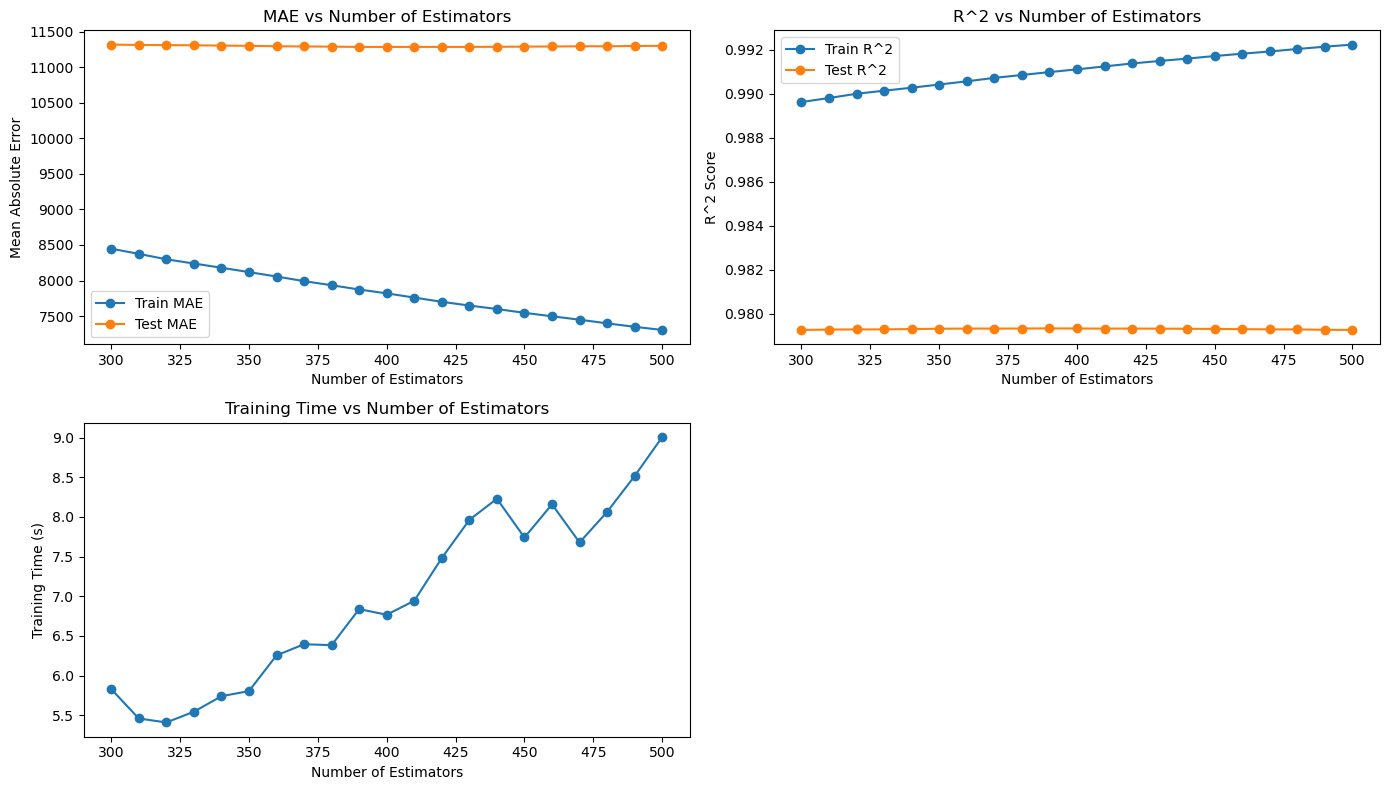

In [108]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = range(300, 501, 10)
results = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

##### 가장 성능이 좋았던 모델
- n_estimators = 400

In [109]:
model = XGBRegressor(
    max_depth=10,
    n_estimators = 400,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=77
)

In [110]:
model.fit(
        X_train,
        y_train
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [30]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7819.524937618889, Train R^2: 0.991114439602105
Test MAE: 11282.95493659433, Test R^2: 0.9793234393475061


In [31]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-11489.21441963 -11533.66783248 -11474.2280225  -11337.37736086
 -11530.38920203]
교차 검증 MAE 점수: [11489.21441963 11533.66783248 11474.2280225  11337.37736086
 11530.38920203]
평균 MAE: 11472.975367498357
표준 편차: 71.59890929984391


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

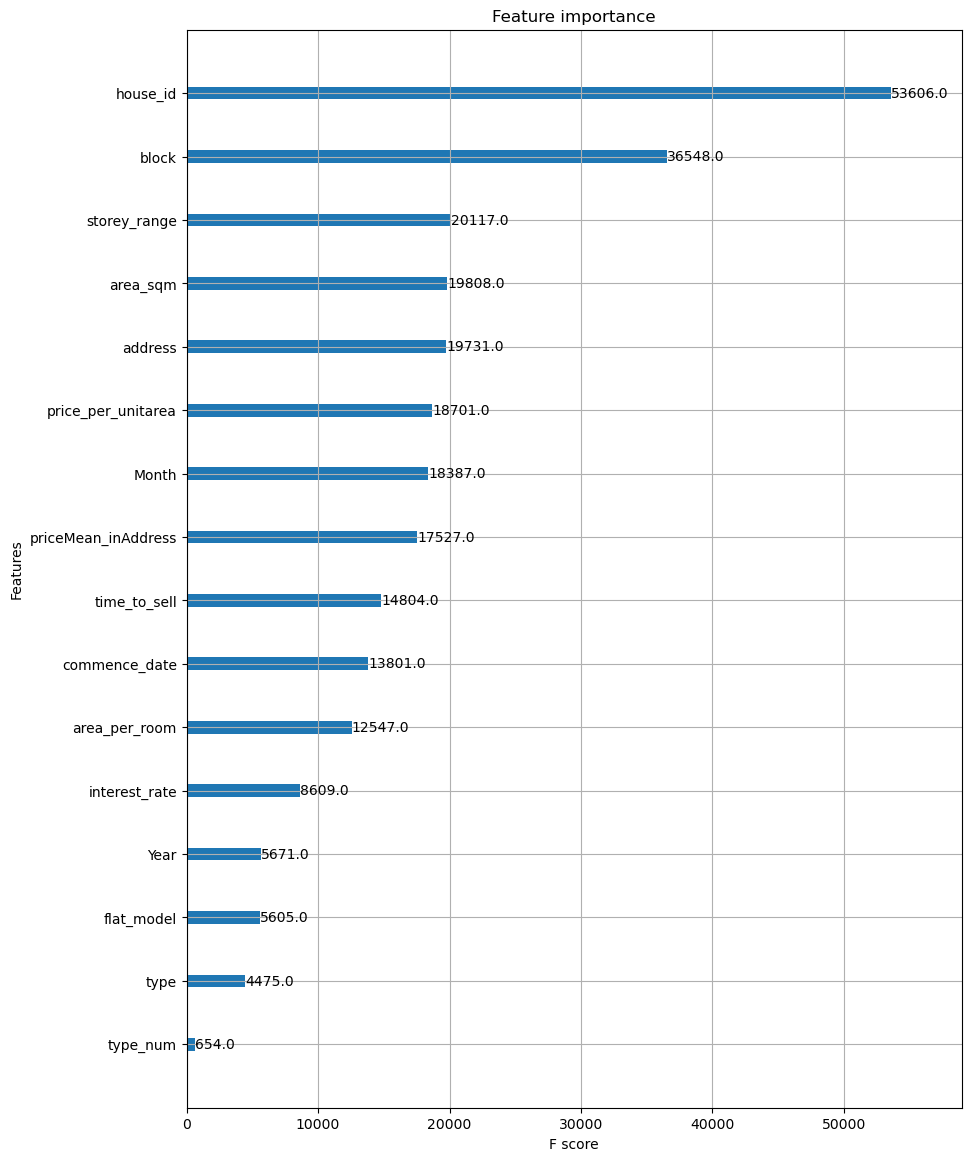

In [ ]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

### CASE 2
- CASE 1에서 time_to_sell을 제거
- 높은 성능을 보인 400회 기준 300~500회 학습 구간 사이를 10회 단위로 나누어 성능확인

In [33]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,price_per_unitarea,price_per_room,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,0.252286,0.0,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,0.284789,0.0,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,0.175957,0.0,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,0.160477,0.0,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,0.208204,0.0,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,0.214976,0.0,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0.227267,0.0,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,0.251966,0.0,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,0.261475,0.0,10,8,0.260870,0.00


In [35]:
X = train.drop(['price', 'price_per_unitarea', 'price_per_room', 'time_to_sell'], axis = 1)
y = train['price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    n_estimators    train_mae      test_mae  train_r2   test_r2      time
0            300  8445.887882  11319.814908  0.989640  0.979349  6.257624
1            310  8383.960037  11310.764647  0.989791  0.979367  6.554667
2            320  8312.659211  11304.987301  0.989973  0.979379  5.527625
3            330  8249.361788  11301.060337  0.990122  0.979389  5.754322
4            340  8182.295148  11296.815628  0.990281  0.979395  5.687374
5            350  8117.421944  11294.818563  0.990439  0.979405  6.045813
6            360  8057.543445  11291.436256  0.990574  0.979410  6.268875
7            370  7997.092703  11290.603745  0.990716  0.979407  6.810938
8            380  7941.109762  11285.902197  0.990842  0.979412  6.385971
9            390  7881.029671  11286.077682  0.990979  0.979403  6.121145
10           400  7826.973552  11287.759878  0.991101  0.979390  6.226902
11           410  7770.015662  11287.592523  0.991230  0.979385  6.466046
12           420  7715.284287  11289.7

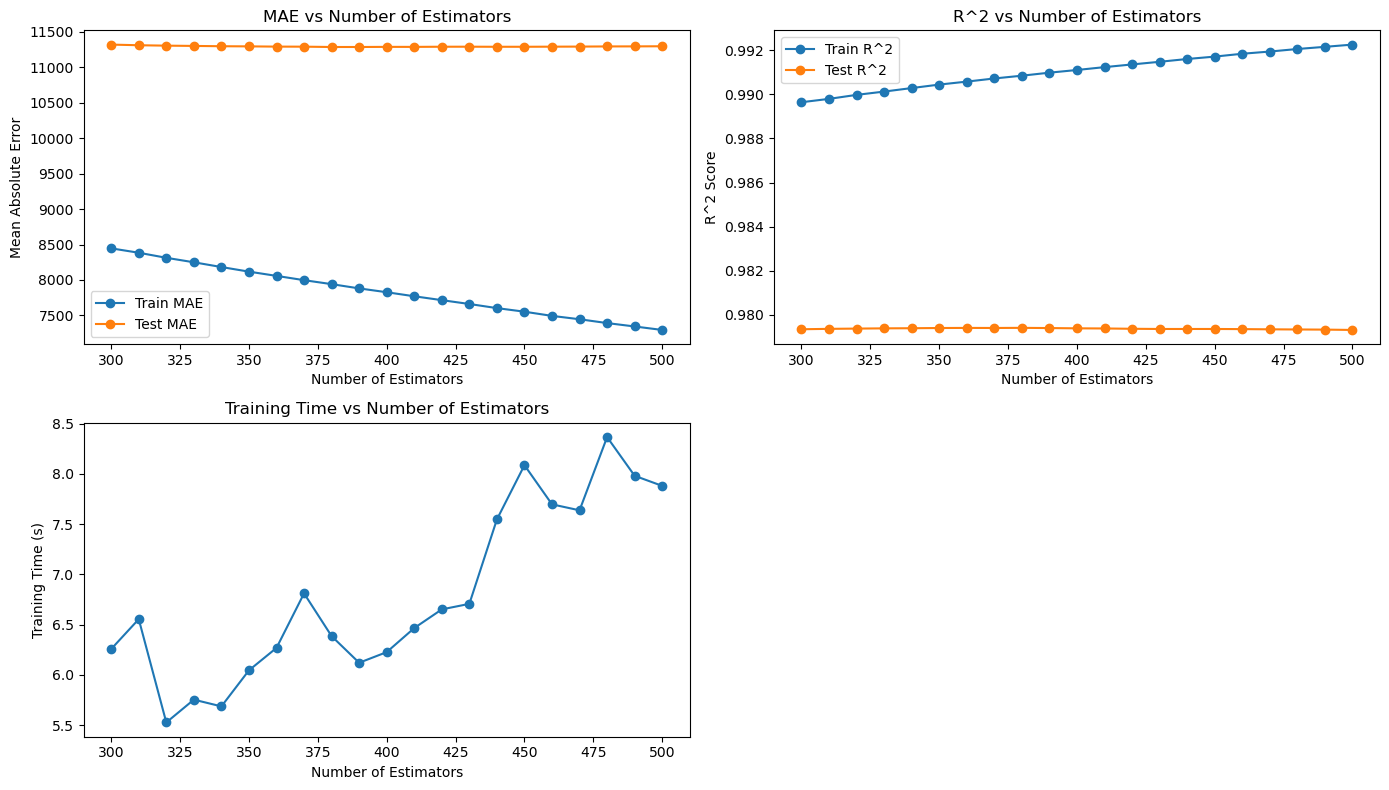

In [37]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = range(300, 501, 10)
results = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

##### 가장 성능이 좋았던 모델
- n_estimators = 380

In [111]:
model = XGBRegressor(
    max_depth=10,
    n_estimators = 380,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=77
)

In [112]:
model.fit(
        X_train,
        y_train
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=380,
             n_jobs=None, num_parallel_tree=None, ...)

In [113]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7933.86365300361, Train R^2: 0.9908593383210444
Test MAE: 11287.309022541172, Test R^2: 0.9793227803152528


In [114]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-11490.60212464 -11539.01252483 -11474.17008789 -11337.50964809
 -11528.2039084 ]
교차 검증 MAE 점수: [11490.60212464 11539.01252483 11474.17008789 11337.50964809
 11528.2039084 ]
평균 MAE: 11473.899658771135
표준 편차: 72.20791835440407


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

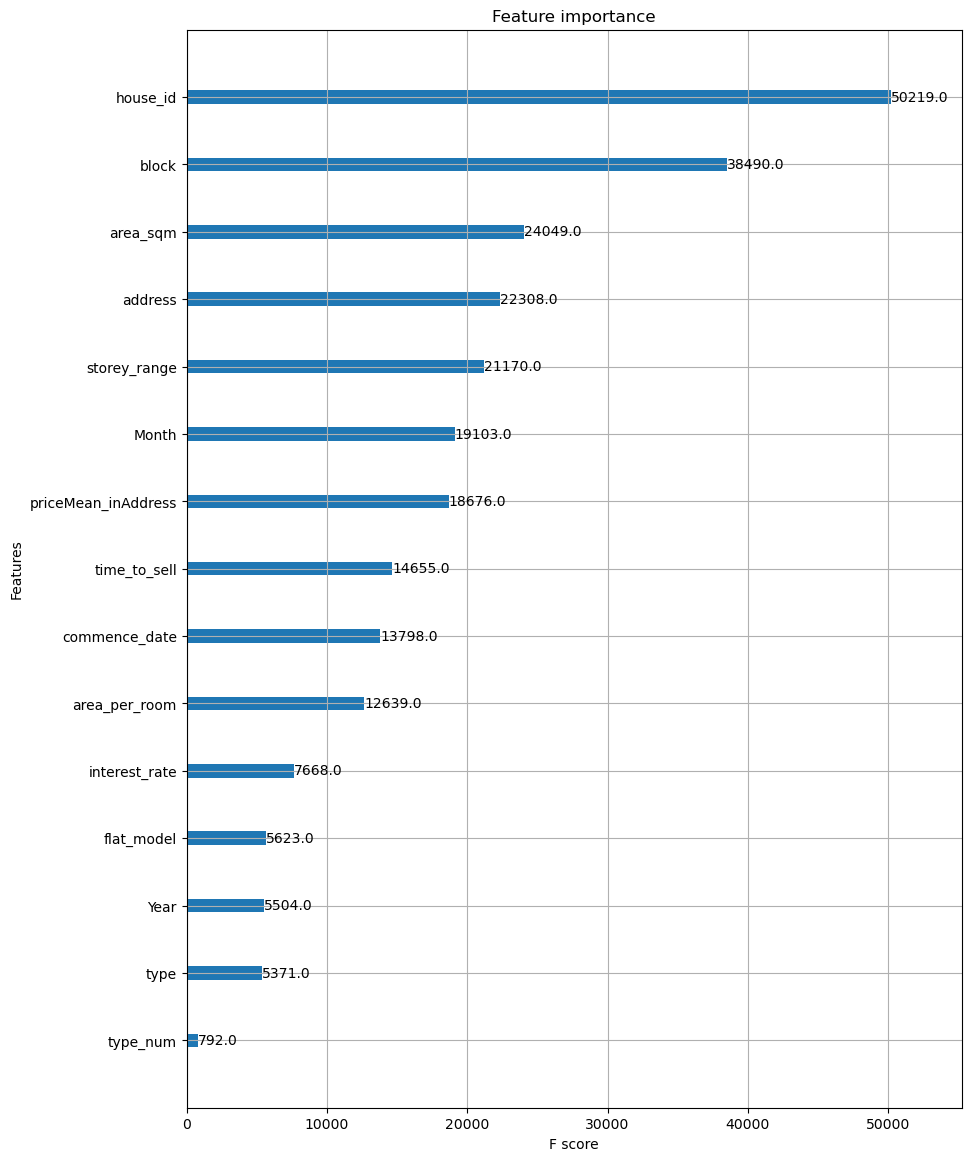

In [115]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

### CASE 3
- CASE 1에서 interest_rate를 제거
- 높은 성능을 보인 400회 기준 300~500회 학습 구간 사이를 10회 단위로 나누어 성능확인

In [116]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,10,8,0.260870,0.00


In [117]:
X = train.drop(['price', 'interest_rate'], axis = 1)
y = train['price']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    n_estimators    train_mae      test_mae  train_r2   test_r2      time
0            300  8449.779824  11314.977827  0.989651  0.979349  5.539978
1            310  8381.312917  11310.209544  0.989825  0.979359  5.850893
2            320  8316.338683  11309.670798  0.989984  0.979358  6.444144
3            330  8259.864531  11303.276678  0.990112  0.979371  6.603075
4            340  8197.659502  11299.749422  0.990256  0.979375  6.427022
5            350  8142.391909  11301.570920  0.990386  0.979370  5.976664
6            360  8088.461196  11296.748558  0.990511  0.979385  6.041373
7            370  8034.679892  11293.383156  0.990632  0.979387  6.194928
8            380  7969.240603  11290.135078  0.990786  0.979392  6.325581
9            390  7913.793629  11288.283703  0.990912  0.979394  6.518949
10           400  7858.274127  11290.584668  0.991041  0.979380  6.564140
11           410  7802.174096  11289.891331  0.991169  0.979377  6.762012
12           420  7750.384670  11292.4

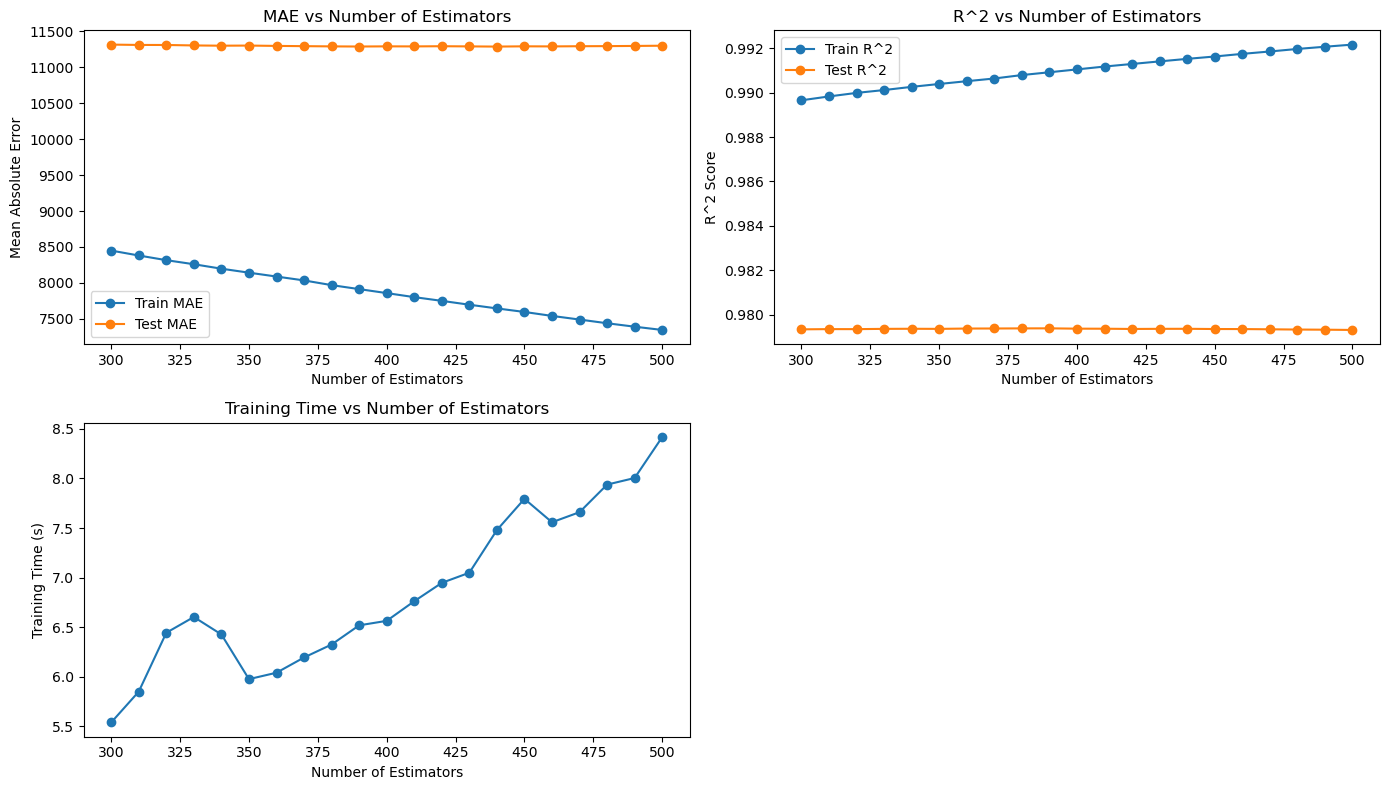

In [119]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = range(300, 501, 10)
results = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

##### 가장 성능이 좋았던 모델
- n_estimators = 440

In [120]:
model = XGBRegressor(
    max_depth=10,
    n_estimators = 440,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=77
)

In [121]:
model.fit(
        X_train,
        y_train
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=440,
             n_jobs=None, num_parallel_tree=None, ...)

In [122]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7645.288058245706, Train R^2: 0.9915148585747358
Test MAE: 11287.35882911549, Test R^2: 0.9793740457415333


In [123]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-11507.56161504 -11529.29722491 -11500.20560349 -11356.83076515
 -11518.12970035]
교차 검증 MAE 점수: [11507.56161504 11529.29722491 11500.20560349 11356.83076515
 11518.12970035]
평균 MAE: 11482.404981786705
표준 편차: 63.55114506270286


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

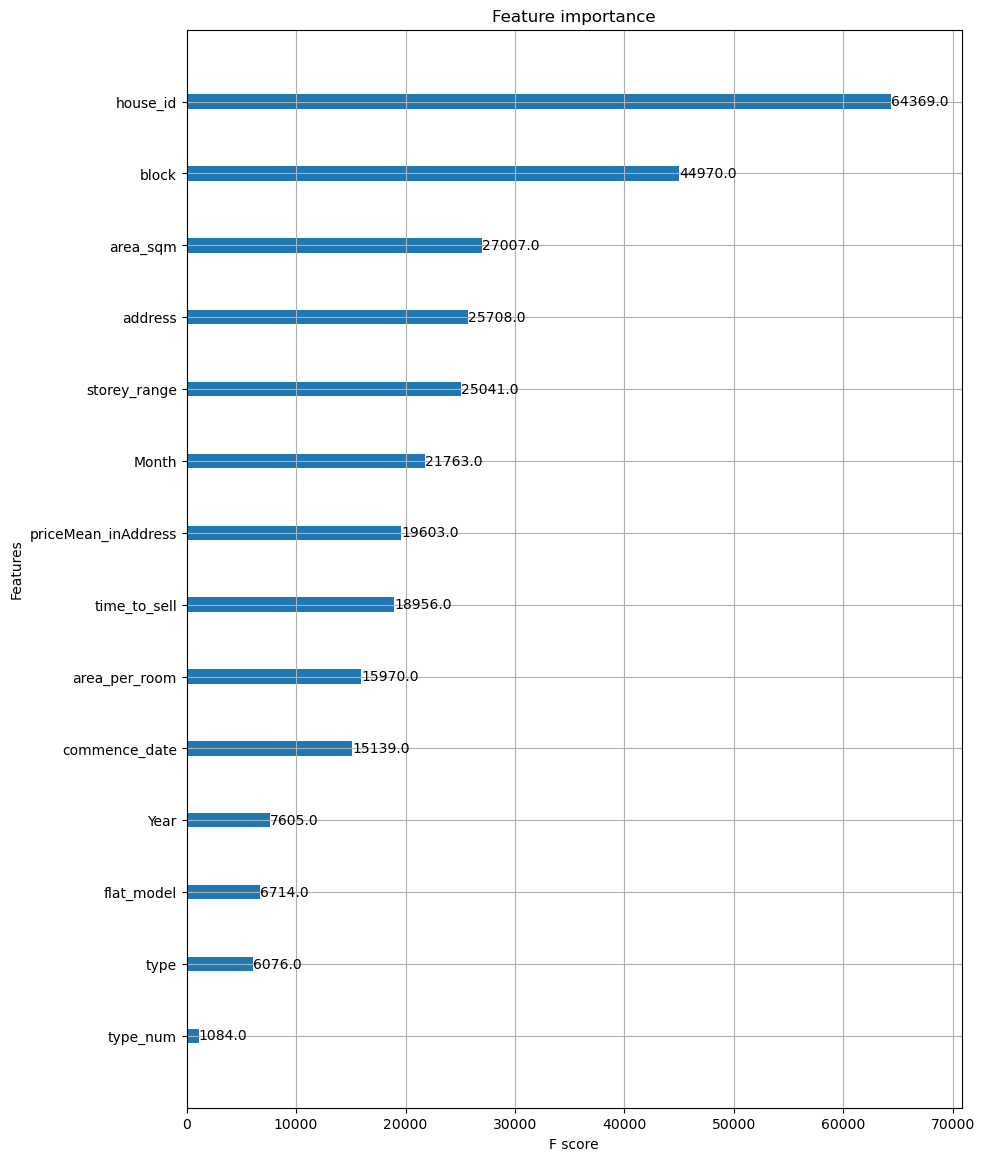

In [124]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

### CASE 4
- CASE 1에서 time_to_sell, interest_rate를 제거
- 높은 성능을 보인 400회 기준 300~500회 학습 구간 사이를 10회 단위로 나누어 성능확인

In [157]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,10,8,0.260870,0.00


In [158]:
X = train.drop(['price', 'time_to_sell', 'interest_rate'], axis = 1)
y = train['price']

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    n_estimators    train_mae      test_mae  train_r2   test_r2      time
0            300  8539.814966  11300.385264  0.989410  0.979383  5.495578
1            310  8472.476705  11296.563893  0.989578  0.979396  5.974945
2            320  8407.756603  11289.913840  0.989733  0.979408  5.939097
3            330  8350.988424  11288.973277  0.989873  0.979402  5.925992
4            340  8289.379839  11281.797666  0.990018  0.979413  6.290142
5            350  8231.950872  11277.668010  0.990156  0.979415  6.102971
6            360  8167.503982  11271.834528  0.990313  0.979431  6.278354
7            370  8107.143628  11269.877732  0.990454  0.979428  6.362040
8            380  8046.823931  11267.754501  0.990589  0.979427  6.586678
9            390  7986.229095  11266.352025  0.990729  0.979428  6.702570
10           400  7932.929282  11267.338671  0.990850  0.979423  6.820104
11           410  7879.195136  11265.255627  0.990971  0.979425  7.556994
12           420  7821.224071  11266.8

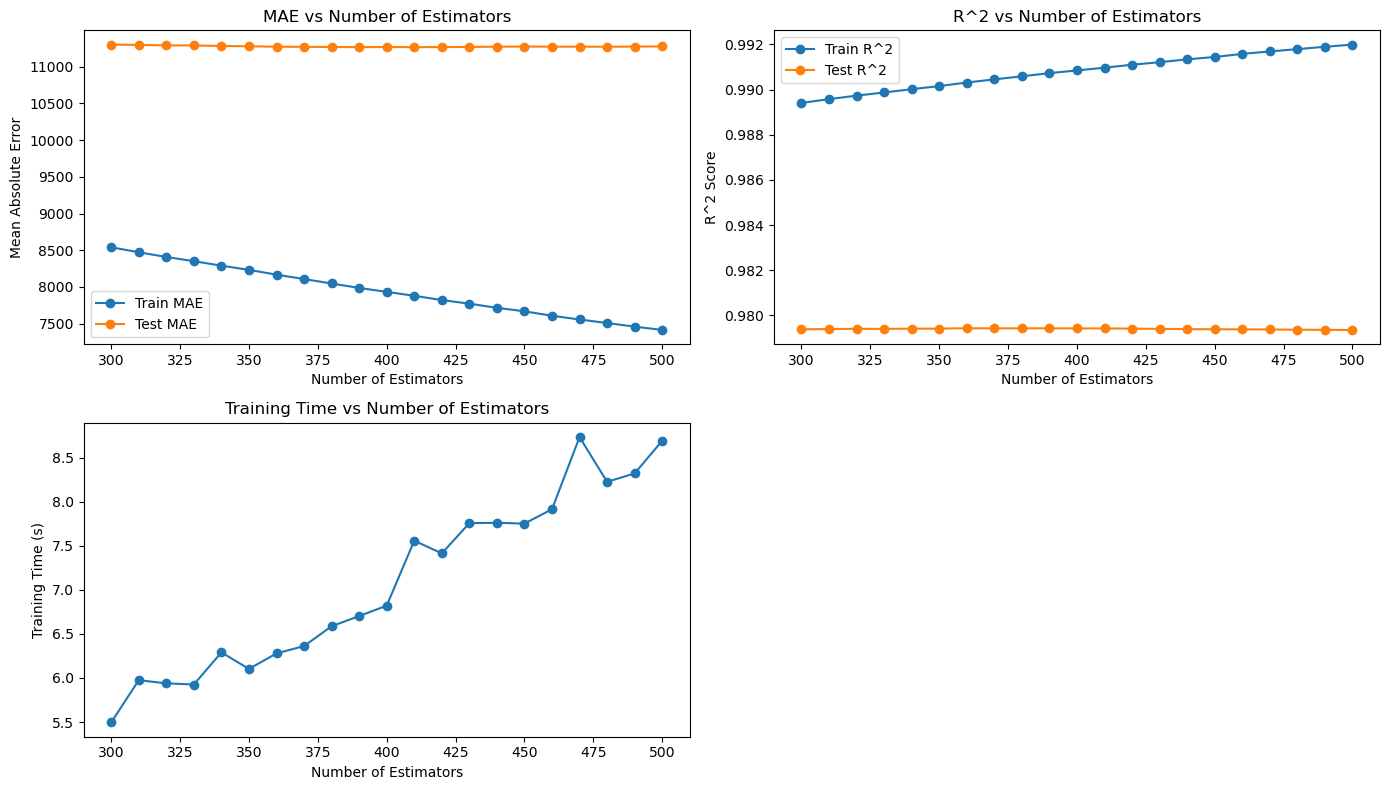

In [160]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = range(300, 501, 10)
results = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

##### 가장 성능이 좋았던 모델
- n_estimators = 410

In [161]:
model = XGBRegressor(
    max_depth=10,
    n_estimators = 410,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=77
)

In [162]:
model.fit(
        X_train,
        y_train
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=410,
             n_jobs=None, num_parallel_tree=None, ...)

In [163]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7879.195136022231, Train R^2: 0.99097054459474
Test MAE: 11265.255627492756, Test R^2: 0.9794245596153043


In [164]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-11484.04431406 -11551.62109405 -11484.03487498 -11367.12567539
 -11553.58925361]
교차 검증 MAE 점수: [11484.04431406 11551.62109405 11484.03487498 11367.12567539
 11553.58925361]
평균 MAE: 11488.083042417618
표준 편차: 67.81081231452437


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

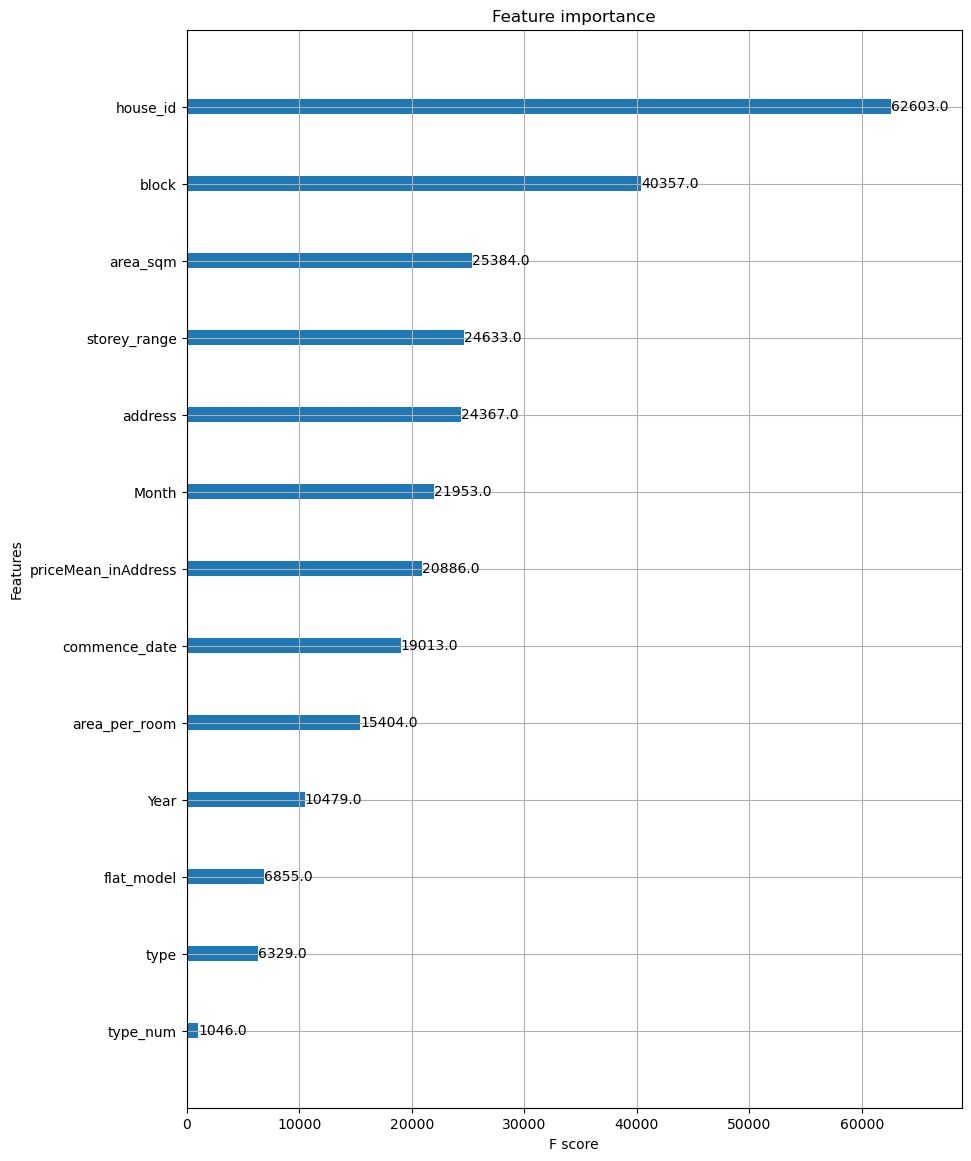

In [165]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

### CASE 5
- CASE 1에서 time_to_sell, interest_rate, type_num을 제거
- 앞선 모든 CASE에서 낮은 중요도를 보인 type_num을 함께 제거
- 높은 성능을 보인 400회 기준 300~500회 학습 구간 사이를 10회 단위로 나누어 성능확인

In [166]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,10,8,0.260870,0.00


In [167]:
X = train.drop(['price', 'time_to_sell', 'interest_rate', 'type_num'], axis = 1)
y = train['price']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    n_estimators    train_mae      test_mae  train_r2   test_r2      time
0            300  8534.137953  11270.454619  0.989418  0.979523  6.126590
1            310  8473.476269  11264.892486  0.989570  0.979539  5.628769
2            320  8410.142700  11262.086837  0.989730  0.979542  5.544497
3            330  8349.070708  11260.277908  0.989887  0.979546  5.713173
4            340  8288.529121  11255.159238  0.990031  0.979552  6.206744
5            350  8230.608987  11253.414478  0.990168  0.979553  6.065693
6            360  8166.387433  11249.869728  0.990320  0.979559  6.465805
7            370  8107.617093  11249.570433  0.990459  0.979555  6.496335
8            380  8044.075226  11249.020031  0.990607  0.979559  6.545346
9            390  7989.661335  11249.591559  0.990734  0.979553  6.810216
10           400  7931.889069  11246.669330  0.990868  0.979550  6.778317
11           410  7876.649071  11248.207471  0.990994  0.979547  7.028871
12           420  7825.419199  11244.5

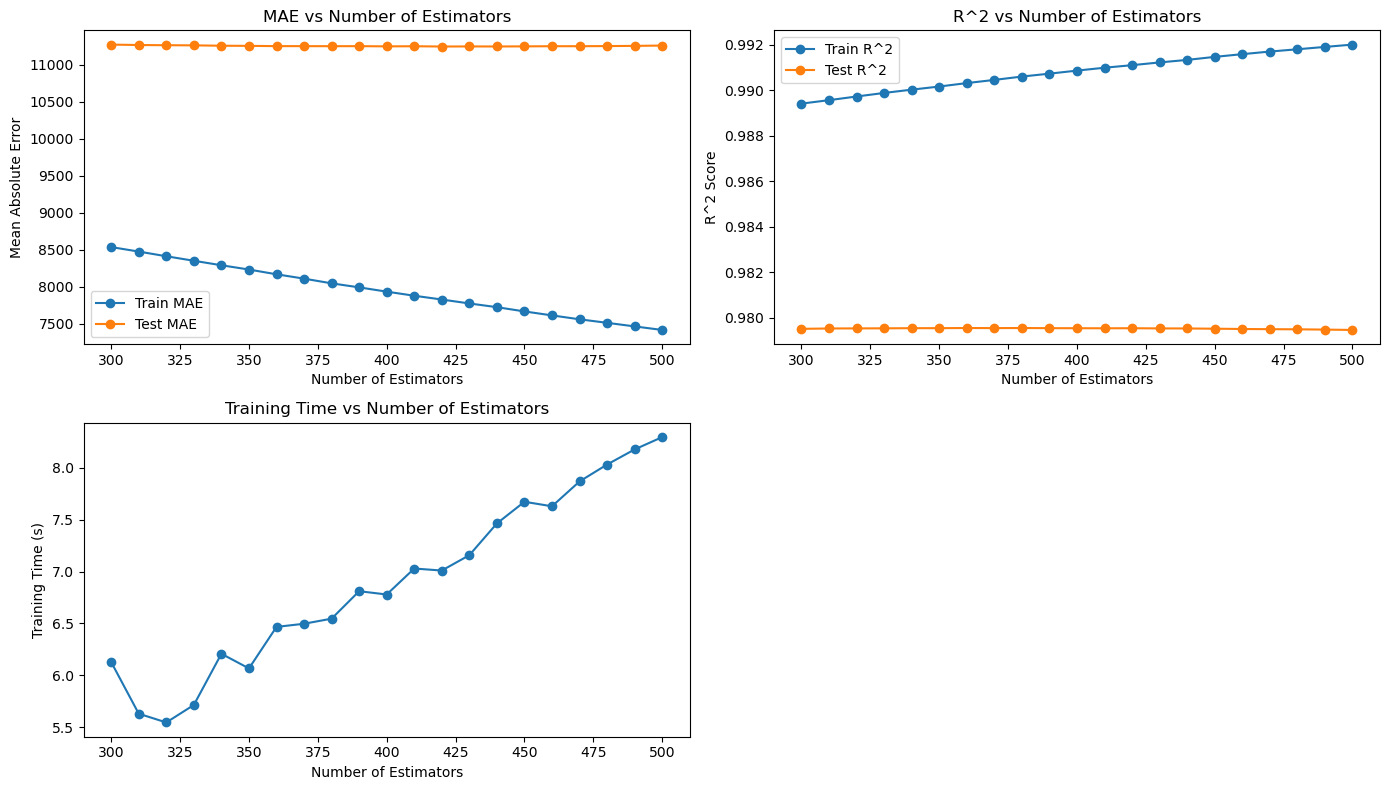

In [169]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = range(300, 501, 10)
results = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

##### 가장 성능이 좋았던 모델
- n_estimators = 420

In [179]:
model = XGBRegressor(
    max_depth=10,
    n_estimators = 420,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=77
)

In [180]:
model.fit(
        X_train,
        y_train
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=420,
             n_jobs=None, num_parallel_tree=None, ...)

In [181]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7825.4191994667335, Train R^2: 0.9911067841196977
Test MAE: 11244.553712140032, Test R^2: 0.9795501863967924


In [182]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-11450.59198952 -11487.7458303  -11509.21662343 -11377.48790696
 -11534.00220219]
교차 검증 MAE 점수: [11450.59198952 11487.7458303  11509.21662343 11377.48790696
 11534.00220219]
평균 MAE: 11471.808910477837
표준 편차: 54.53061044007871


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

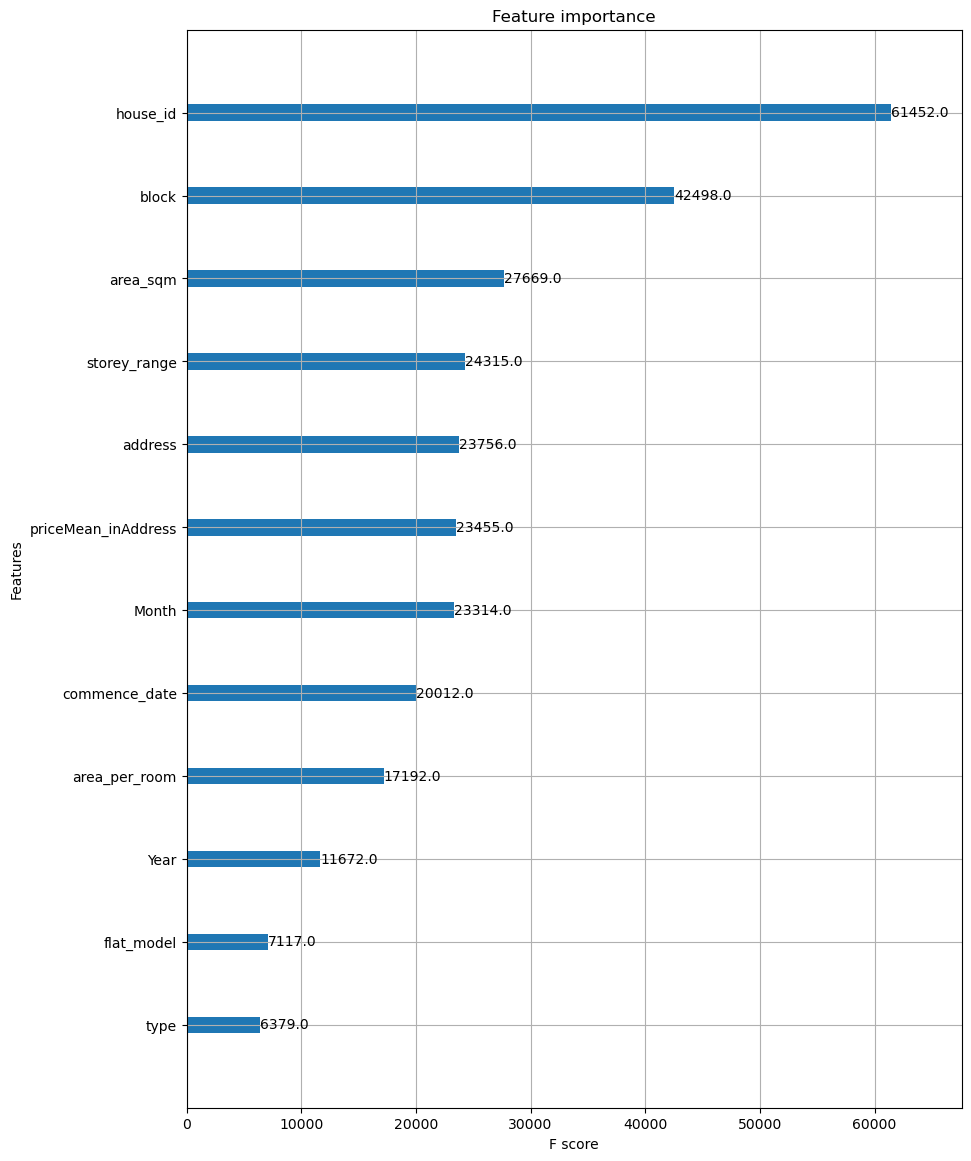

In [183]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

### CASE 6
- CASE 1에서 time_to_sell, interest_rate, Month를 제거
- price와의 상관계수가 상당히 낮은 세 피쳐를 제거
- 높은 성능을 보인 400회 기준 300~500회 학습 구간 사이를 10회 단위로 나누어 성능확인

In [206]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,10,8,0.260870,0.00


In [207]:
X = train.drop(['price', 'time_to_sell', 'interest_rate', 'Month'], axis = 1)
y = train['price']

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    n_estimators    train_mae      test_mae  train_r2   test_r2       time
0            300  8695.778396  11256.998314  0.989008  0.979654   5.894942
1            310  8634.775704  11249.289202  0.989166  0.979674   5.713595
2            320  8575.016390  11245.851627  0.989321  0.979684   5.659989
3            330  8521.257734  11236.203744  0.989451  0.979706   5.696563
4            340  8459.967987  11226.968094  0.989598  0.979732   5.766001
5            350  8403.300366  11222.429812  0.989733  0.979740   5.918917
6            360  8353.557938  11218.946254  0.989853  0.979750   6.067840
7            370  8296.725962  11216.262840  0.989994  0.979745   6.239670
8            380  8243.591943  11210.902702  0.990119  0.979759   6.395341
9            390  8186.620928  11207.409345  0.990253  0.979762   6.502070
10           400  8134.435630  11205.228132  0.990386  0.979761   6.639959
11           410  8086.863953  11206.167847  0.990496  0.979747   6.916592
12           420  8033.45

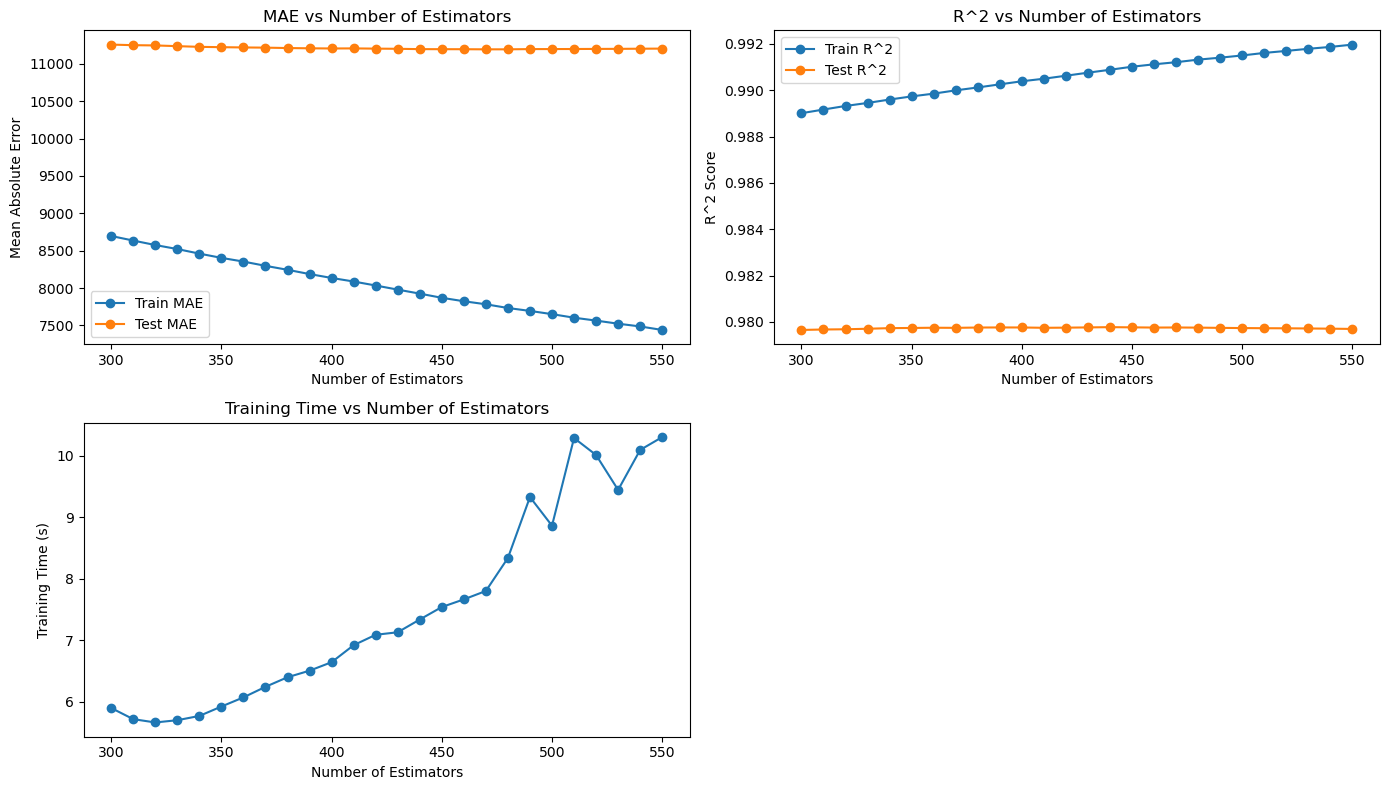

In [210]:
# 다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
# 범위가 500까지로는 확인이 부족
n_estimators_list = range(300, 551, 10)
results = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

##### 가장 성능이 좋았던 모델
- n_estimators = 470

In [211]:
model = XGBRegressor(
    max_depth=10,
    n_estimators = 470,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=77
)

In [212]:
model.fit(
        X_train,
        y_train
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=470,
             n_jobs=None, num_parallel_tree=None, ...)

In [213]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7782.342519858303, Train R^2: 0.991209043205489
Test MAE: 11193.635111113028, Test R^2: 0.9797606902962727


In [214]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-11350.8083964  -11415.887703   -11385.49495572 -11278.15903378
 -11452.13428074]
교차 검증 MAE 점수: [11350.8083964  11415.887703   11385.49495572 11278.15903378
 11452.13428074]
평균 MAE: 11376.49687393061
표준 편차: 59.47074723344989


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

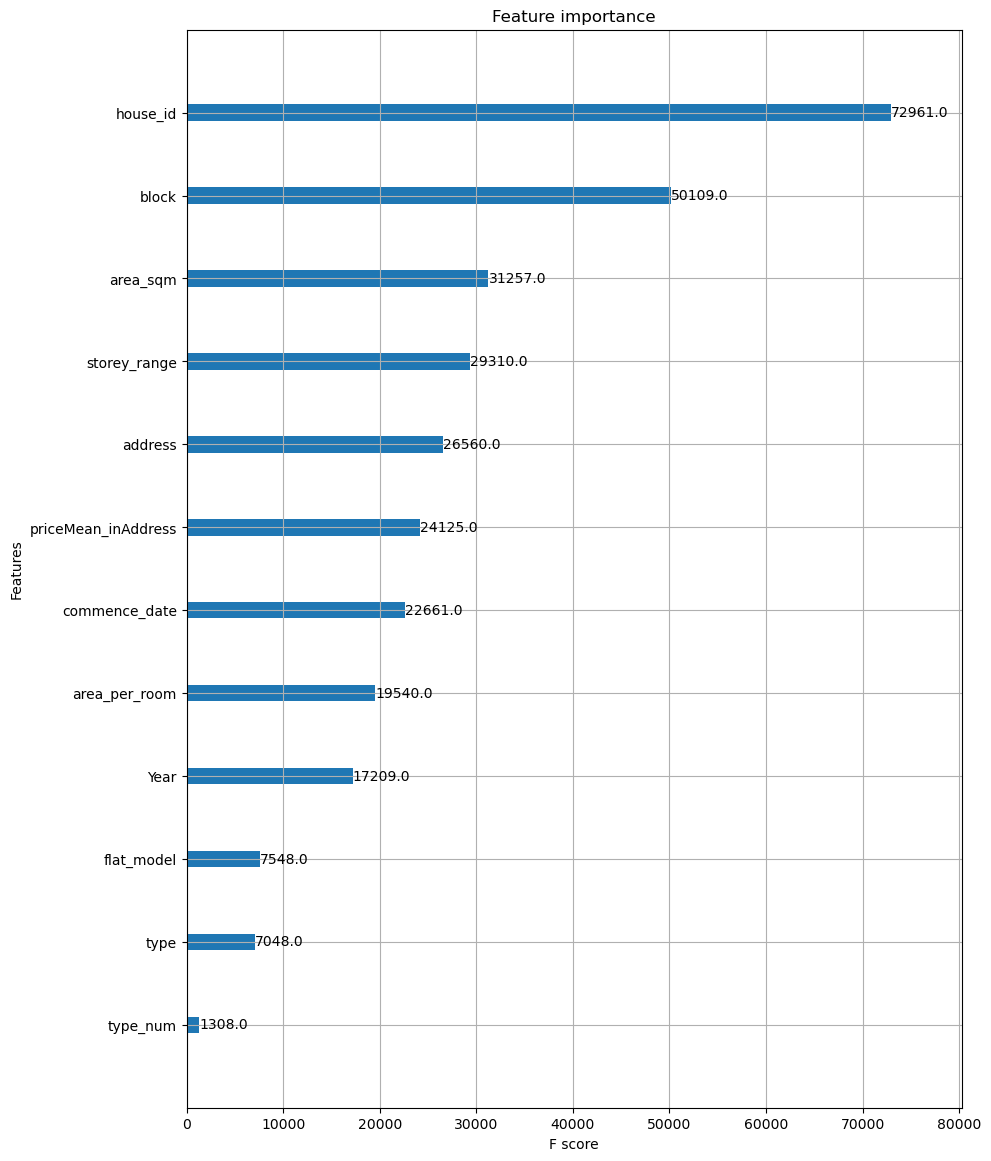

In [215]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))